n_j = 2


100%|██████████| 21/21 [06:28<00:00, 18.48s/it]


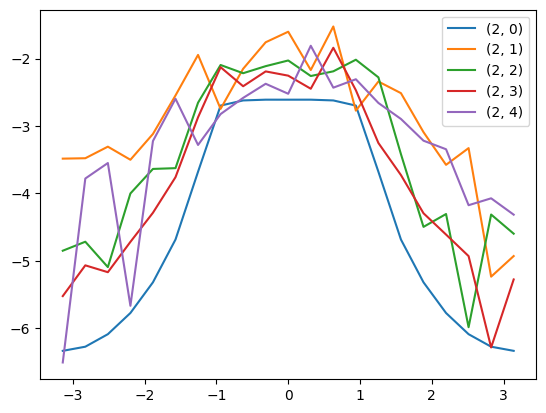

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy import constants, sparse
import Sub180221 as Sub
import time


class Flux:
    def __init__(self, E_Jb=7.5e9, C_Jb=40e-15, C_J=32.9e-15,
                 N_J=10, N_truncation=10, Ds=8, N_excited=5,
                 if_same_E_J=True, if_same_C_J=True,
                 basis='charge'):
        self.phi_ext = 0
        assert if_same_C_J and if_same_E_J, 'default same E_J, C_J'  # TODO: C_J, E_J as array
        self.E_J = self.E_Jb = E_Jb * 1e-9
        self.C_Jb = C_Jb
        self.C_J = C_J
        self.E_C = constants.e ** 2 / 2 / self.C_J / constants.h * 1e-9

        self.N_J = N_J
        self.N_truncation = N_truncation
        self.scale_ = N_truncation * 2 + 1
        self.Ds = Ds  # maximal bond dimension
        self.n_g = 0
        self.N_excited = N_excited

        self.H_loc = None
        self.MPO = None
        phi_ext = 0
        self.L_bond = np.array([1, 0, 0.5 * self.E_Jb, 0.5 * self.E_Jb]).reshape((1, 4, 1))
        self.R_bond = np.array([0, 1, np.exp(1j * phi_ext), np.exp(-1j * phi_ext)]).reshape((1, 4, 1))
        self.HL = [None for _ in range(N_J)]
        self.HL[0] = self.L_bond
        self.HR = [None for _ in range(N_J)]
        self.HR[-1] = self.R_bond
        self.T = []
        self.psis = []
        self.Eng = []
        self.psiL = [[None for _ in range(N_J)] for _ in range(N_excited)]
        self.psiR = [[None for _ in range(N_J)] for _ in range(N_excited)]
        self.init_MPS(0)
        self.set_MPO(basis)

    def init_MPS(self, level: int):
        self.T = []
        for i in range(self.N_J):
            Dl = min(self.scale_ ** i, self.scale_ ** (self.N_J - i), self.Ds)
            Dr = min(self.scale_ ** (i + 1), self.scale_ ** (self.N_J - 1 - i), self.Ds)
            self.T.append(np.random.rand(Dl, self.scale_, Dr))

        U = np.eye(np.shape(self.T[-1])[-1])
        for i in range(self.N_J - 1, 0, -1):
            U, self.T[i] = Sub.Mps_LQP(self.T[i], U)

        for L in range(level):
            self.psiL[L][0] = np.array([1]).reshape((1, 1))
            self.psiR[L][-1] = np.array([1]).reshape((1, 1))
            for i in range(self.N_J - 1, 0, -1):
                self.psiR[L][i - 1] = Sub.NCon([
                    self.psiR[L][i], self.T[i], self.psis[L][i]
                ], [
                    [1, 3], [-1, 2, 1], [-2, 2, 3]
                ])

    def set_MPO(self, basis: str):
        if basis == 'charge':
            cos_theta = 0.5 * np.eye(self.scale_, k=1) + 0.5 * np.eye(self.scale_, k=-1)
            sin_theta = -0.5j * np.eye(self.scale_, k=1) + 0.5j * np.eye(self.scale_, k=-1)
            exp_i_theta = cos_theta + 1j * sin_theta
            n_operator = np.diag(np.arange(-self.N_truncation, self.N_truncation + 1))
            n_g = np.diag(np.array([0] * self.scale_))
            self.H_loc = 4 * self.E_C * (n_operator - n_g) ** 2 - self.E_J * cos_theta
        elif basis == 'flux':
            phi = np.linspace(-0.5 * np.pi, 0.5 * np.pi, self.scale_)
            dphi = phi[-1] - phi[-2]
            cos_theta = np.diag(np.cos(phi))
            sin_theta = np.diag(np.sin(phi))
            exp_i_theta = cos_theta + 1j * sin_theta
            n_operator = 1j / 2 / dphi * np.eye(self.scale_, k=1) - 1j / 2 / dphi * np.eye(self.scale_, k=-1)
            n_g = self.n_g * np.eye(self.scale_, k=1) - self.n_g * np.eye(self.scale_, k=-1)
            self.H_loc = (4 * self.E_C * np.multiply(n_operator - n_g, n_operator - n_g)
                          - self.E_J * cos_theta)
        else:
            print('Not available basis')
            return None
        assert self.H_loc.shape == exp_i_theta.shape == (self.scale_, self.scale_)
        self.MPO = np.zeros((4, self.scale_, 4, self.scale_), dtype=complex)
        self.MPO[0, :, 0, :] = np.identity(self.scale_)
        self.MPO[0, :, 1, :] = self.H_loc
        self.MPO[1, :, 1, :] = np.identity(self.scale_)
        self.MPO[2, :, 2, :] = exp_i_theta
        self.MPO[3, :, 3, :] = exp_i_theta.conj()
        return self.MPO

    def set_phiExt(self, phi_ext: float):
        self.phi_ext = phi_ext
        self.R_bond = np.array([0, 1, np.exp(1j * phi_ext), np.exp(-1j * phi_ext)]).reshape((1, 4, 1))
        self.HR[-1] = self.R_bond
        for i in range(self.N_J - 1, 0, -1):
            # print(i)
            # HR = np.einsum('ijk,lmjn->inlmk', self.HR[i], self.MPO)
            # HR = np.einsum('qni,inlmk->qlmk', self.T[i], HR)
            # self.HR[i-1] = np.einsum('ilmk,jmk->ilj', np.conj(self.T[i]), HR)
            self.HR[i - 1] = Sub.NCon([
                self.HR[i], self.T[i], self.MPO, np.conj(self.T[i])
            ], [
                [1, 3, 5], [-1, 2, 1], [-2, 2, 3, 4], [-3, 4, 5]
            ])

    def optimizeTsite(self, site_: int, level: int):
        HL, HR, T = self.HL[site_], self.HR[site_], self.T[site_]
        assert isinstance(HL, np.ndarray) and isinstance(HR, np.ndarray) and isinstance(T, np.ndarray)
        assert len(HL.shape) == len(HR.shape) == 3
        assert HL.shape[1] == HR.shape[1] == self.MPO.shape[0] == self.MPO.shape[2]
        A = np.einsum('ijk,jlmn->ilmnk', HL, self.MPO)
        A = np.einsum('ilmnk,jmp->iljknp', A, HR)
        psi3 = np.zeros(A.shape[:3])
        for L in range(level):
            psi3 = psi3 - self.Eng[L] * Sub.NCon([
                self.psiL[L][site_], self.psis[L][site_], self.psiR[L][site_]
            ], [
                [-1, 1], [1, -2, 2], [-3, 2]
            ])
        assert A.shape[:3] == psi3.shape
        A = A + np.tensordot(psi3, np.conj(psi3), 0)
        A = np.reshape(A, (A.shape[0] * A.shape[1] * A.shape[2], A.shape[3] * A.shape[4] * A.shape[5]))
        Eig, V = sparse.linalg.eigsh(A, k=1, which='SA')
        T = np.reshape(V, np.shape(T))
        return T, Eig

    def optimizeT(self, level: int):
        self.init_MPS(level)
        Eng0 = np.zeros(self.N_J)
        Eng1 = np.zeros(self.N_J)
        ts = time.time()
        for r in range(100):
            # print(r)

            for i in range(self.N_J - 1):
                self.T[i], Eng1[i] = self.optimizeTsite(i, level)
                self.T[i], U = Sub.Mps_QR0P(self.T[i])
                self.HL[i + 1] = Sub.NCon([
                    self.HL[i], np.conj(self.T[i]), self.MPO, self.T[i]
                ], [
                    [1, 3, 5], [1, 2, -1], [3, 4, -2, 2], [5, 4, -3]
                ])
                self.T[i + 1] = np.tensordot(U, self.T[i + 1], (1, 0))
                for L in range(level):
                    self.psiL[L][i + 1] = Sub.NCon([
                        self.psiL[L][i], self.T[i], self.psis[L][i]
                    ], [
                        [1, 3], [1, 2, -1], [3, 2, -2]
                    ])

            for i in range(self.N_J - 1, 0, -1):
                self.T[i], Eng1[i] = self.optimizeTsite(i, level)
                U, self.T[i] = Sub.Mps_LQ0P(self.T[i])
                self.HR[i - 1] = Sub.NCon([
                    self.HR[i], self.T[i], self.MPO, np.conj(self.T[i])
                ], [
                    [1, 3, 5], [-1, 2, 1], [-2, 2, 3, 4], [-3, 4, 5]
                ])
                self.T[i - 1] = np.tensordot(self.T[i - 1], U, (2, 0))
                for L in range(level):
                    self.psiR[L][i - 1] = Sub.NCon([
                        self.psiR[L][i], self.T[i], self.psis[L][i]
                    ], [
                        [1, 3], [-1, 2, 1], [-2, 2, 3]
                    ])

            if time.time() - ts > 60:
                print('using > 60 s, break')
                return 0

            # print(Eng1)
            if abs(Eng1[1] - Eng0[1]) < 1e-5:
                break
            Eng0 = Eng1.copy()

        self.Eng.append(Eng1[1] / self.N_J)

        self.psis.append(self.T.copy())

        # print(Eng1/self.N_J)
        return Eng1[1] / self.N_J

    def vMPS(self):
        Eng = []
        for i in range(self.N_excited):
            Eng.append(self.optimizeT(i))
        return Eng


for n_j in range(2, 3):
    n_excited = 5
    phi_ext_range = np.linspace(-np.pi, np.pi, 21)  # the sweep range of phi_ext
    energies = np.zeros((len(phi_ext_range), n_excited))
    f = Flux(N_J=n_j, N_excited=n_excited, Ds=4)
    print('n_j =', n_j)
    for cnt, var in enumerate(tqdm(phi_ext_range)):
        f.set_phiExt(var)
        energies[cnt] = np.array(f.vMPS())
    for j in range(n_excited):
        plt.plot(phi_ext_range, energies[:, j], label=(n_j, j))
plt.legend()
# plt.savefig('test.pdf')
